# Global Cuisines and Where to Find Them:
### Investigate the food diversity in London using Yelp Fusion API

Yunjing Hu<br>
CASA0006 Data Science for Spatial System<br>
Final Coursework

## Table of Contents
* [**1. Introduction**](#introduction)
    * [**1.1 Context and Objectives**](#context)
    * [**1.2 Research Question**](#researchq)
    * [**1.3 Dataset Overview**](#dataset)
    * [**1.4 General Workflow and Methods**](#workflow)
* [**2. Data Preperation**](#preperation)
    * [**2.1 Data Retrieving**](#retrieving)
    * [**2.2 Data Preprocessing**](#preprocessing)
    * [**2.3 Spatial Aggregation**](#aggregation)
        * [**2.3.1 Data Transformation**](#transformation)
        * [**2.3.2 Spatial Join**](#join)
            * [**Data Complementing and Re-processing**](#revisit)
            * [**Spatial Join**](#rejoin)
        * [**2.3.3 Spatial Dissolve**](#dissolve)
* [**3. Analysis and Result Intepretation**](#analysis)
    * [**3.1 Diversity Score**](#score)
    * [**3.2 Correlation and Regression**](#relationship)
        * [**3.2.1 Correlation**](#correlation)
        * [**3.2.2 Multilinear Regression**](#multilinear)
        * [**3.2.3 Support Vector Regression**](#svr)
* [**4. Conclusion and Limitations**](#conclusion)
* [**References**](#reference)

------------------------------------------------------------------------------------------

## 1. Introduction<a id='introduction'></a>
### 1.1 Context and Objectives<a id='context'></a>
London is famous for being an international metropolitan where people, capital, and resources from all over the world and cultural backgrounds gathered, which lead to a society with great diversity. The diversity in London is an important urban and social topic that has been measured and mapped in [census report](https://data.london.gov.uk/dataset/2011-census-diversity). Based on census data, the report analyzed the diversity in various aspects including ethnicity, nationality, religion, socio-economical status, age structure, household composition, housing tenure, etc., providing a scope to understand the characteristics of local areas and societies. However, more perspectives and data resources can be used to study this phenomenon with other components of the urban society that could have also contributed to the diversity in London. With this being said, in this coursework, the diversity will be evaluated in terms of the available choices of cuisine types in an area.<br>

In the article by Park (2017), the author comprehensively evaluated the ethnic food diversity of several major U.S. cities at census tract level with the Factual API and Google Places API, and analyzed the possible linkage between the food diversity and other neighborhood characteristics including population, ethnicity diversity, income, knowledge, and education. Referring to some ideas of constructing the analytical processes in Park’s paper, this study will map the cuisine diversity in London at ward level with restaurant information retrieved through [Yelp Fusion API](https://www.yelp.com/developers/documentation/v3/business_search) and discuss the relationship between this diversity and other possibly related attributes of a ward. To specify the definition of cuisine type discussed in this coursework, based on available information from Yelp, it refers to dishes related to a certain country, such as Italian cuisine or Chinese cuisine, and is indicated by the category label of restaurants on Yelp.<br>

The objectives of this study are to explore the pattern of food diversity in London as well as provide a different scope to understand the diversity and evaluate the quality of communities. Besides, it is also expected to examine the effectiveness and validity of the open source data from Yelp in providing evidence for urban and social phenomena.<br> 
 
### 1.2 Research Question<a id='researchq'></a>
The analysis in this study is designed to answer the following research questions:
1. How different are wards in food diversity?
2. What is the relationship between the food diversity and other attributes of the neighborhood?

### 1.3 Dataset Overview<a id='dataset'></a>
The main data used is the business information retrieved from Yelp Fusion API Business Endpoint. With the specified searching parameters, the data is returned in json format, including various attributes of businesses on their id, names, locations, categories, ratings, etc.<br> 

The ward level census data used for the relationship analysis was selected from the Census 2011 dataset available on London Datastore and reorganized to a single table. Referring to the related social aspects mentioned in the article of Park (2017), the following attributes were chosen (in the parenthesis are the column names shown on the table): 
-	Ethnicity diversity score (eth_div_score)
-	Percent of population at working age 18-64 (pct_wk_age)
-	Percent of population not born in UK (pct_not_born_uk)
-	Percent of household in which English is the first language of no one (pct_esl_household)
-	Employment Rate (emp_rate)
-	Rate of new registered migrant workers (new_migrant_workers_rate)
-	Medium household income (med_house_income)
-	Average GCSE score (avg_gcse)
-	Percent of population with qualification of Level 4 or higher (pct_level4)

Besides, the boundary shapefile of London wards used to map the diversity score is retrieved from London DataStore.
All of the dataset loaded into this notebook and the json files extracted from API are also available in this [repository](https://github.com/yunjinghu226/CASA0006DSSS.git).


### 1.4 General Workflow and Methods<a id='workflow'></a>
To answer the questions above, the analysis will be conducted with the general steps and Python packages specified below. 
1.	Retrieve information of London restaurants from Yelp Fusion API using `requests 2.21.0`, then convert to and save as json with `json 2.6.0`
2.	Transform the json data to DataFrame and process it with `pandas 0.23.4` and `numpy 1.15.4`
3.	Summarize the cleaned data, and visualize it using `matplotlib 3.0.2` and `squarify 0.4.2`
4.	Join the restaurant data with boundary data, perform spatial aggregation using `geopandas 0.4.1` and `shapely 1.6.4`
5.	Calculate the diversity score with Simpson’s Diversity Index
6.	Analyze the relationship between diversity score and other attributes with `train_test_split` module, `LinearRegression` module, and `SVR` module of `sklearn 0.20.1`


In [2]:
# load the necessary packages
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import squarify as sq
import geopandas as geopd
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

----------------------------------------------------------------

## 2. Data Preperation<a id='preperation'></a>
The aim of this part is to generate a table of food diversity scores of London wards together with other attributes that can be used for further relationship analysis from the original data retrieved. 
### 2.1 Data Retrieving<a id='retrieving'></a>
This part focuses on building three functions to fetch data through Yelp Fusion API, which allows searching for businesses of certain type, location, and category by specifying the request parameters. To request only for businesses that are restaurants in London, the three parameters specified in the request will be set as: `{'term':'restaurants','location':'London','locale':'en_GB'}`. Due to the access limit (50 results for one request and 1,000 in total for one set of parameters) of the API, the requests were send seperately for different categories and repeatedly with different offset argument to make the final dataset as complete as possible.<br>
The category parameter will be specified when the functions are called. The three functions work in a chain to produce a list a restaurants with information on their id, coordinates, and categories. The `search(offset,category)` makes one seach request within certain category, the `business_retriever(category)` repeats the requests to return the maximum number of results within certain category, and the `extractor(categories)` loops through the [list](https://www.yelp.com/developers/documentation/v3/all_category_list) of all available categories to return a full list of restaurants.<br>

In [2]:
# essential arguments used to send api requests
api_key = 'UF5QVpBto76t3r-vYVt0eIXz6Kq-fsRSgggPQHW582_NF88DE0UOMvfBPv68cxs7ngjZKsnjF3xwAP_1YtWcmYAPktZnbNgannn-jc-TG1_M7qdVeopSs-TGDAtyXHYx'
headers = {'Authorization': 'Bearer %s' % api_key}
url = 'https://api.yelp.com/v3/businesses/search'

In [19]:
categories = ['british','scottish','irish','italian','french','spanish','portuguese','austrian','belgian','bulgarian','czech','georgian','german','hungarian','fondue','polish','scandinavian','african','ethiopian','moroccan','mediterranean','greek','kebab','turkish','arabian','pakistani','mideastern','afghani','australian','russian','ukrainian','chinese','taiwanese','indpak','cambodian','indonesian','laotian','malaysian','singaporean','srilankan','thai','vietnamese','japanese','korean','bangladeshi','burmese','filipino','himalayan','asianfusion','mongolian','newamerican','tradamerican','hawaiian','mexican','argentine','brazilian','caribbean','cuban','latin','peruvian']

In [8]:
def search(offset,category):
    # make one search through api and return a list of restaurants (max 50) of certain category in London
    
    params = {'term':'restaurants','location':'London','locale':'en_GB','limit':50,'offset':offset,'categories':category}
    req=requests.get(url, params=params, headers=headers)
    return req.json()['businesses']

In [9]:
def business_retriever(category):
    # retrieve all (or the max possible number of) the restaurants in a certain category through multiple times of searching
    # return the results as a list of dictionaries
    
    cate_results = []
    
    # test number of total restaurants in this category
    params = {'term':'restaurants','location':'London','locale':'en_GB','limit':1,'offset':0,'categories':category}
    req=requests.get(url, params=params, headers=headers)
    
    if req.status_code == 200: # proceed only if the status code is 200
        total = req.json()['total']
        #set the offset number according to the total number of results availale
        if total > 1000:
            print ('There are more than 1000 restaurants under category ',category,' Only the first 1000 will be returned.')
            for offset in range(0,1000,50):
                results = search(offset,category)
                cate_results.extend(results)
        elif total > 50 and total <= 1000:
            for offset in range(0,total,50):
                results = search(offset,category)
                cate_results.extend(results)
        else:
            cate_results.extend(search(0,category))
            
    else:
        print ('Error in retrieving data.')
        
    return cate_results


In [82]:
# Test the function with a certain category to see what the data looks like
test_results = business_retriever('thai')

In [83]:
len(test_results)

357

In [84]:
test_results[0]

{'id': 'hGiblm0l67sLGTtsMvx51A',
 'alias': 'the-churchill-arms-london',
 'name': 'The Churchill Arms',
 'image_url': 'https://s3-media3.fl.yelpcdn.com/bphoto/eDfzFGKTrBK8v2enBxMBWg/o.jpg',
 'is_closed': False,
 'url': 'https://www.yelp.co.uk/biz/the-churchill-arms-london?adjust_creative=AWe7StbXcs_oDgN8nu1wAA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=AWe7StbXcs_oDgN8nu1wAA',
 'review_count': 313,
 'categories': [{'alias': 'pubs', 'title': 'Pubs'},
  {'alias': 'thai', 'title': 'Thai'}],
 'rating': 4.0,
 'coordinates': {'latitude': 51.5068261, 'longitude': -0.194781},
 'transactions': [],
 'price': '££',
 'location': {'address1': '119 Kensington Church Street',
  'address2': '',
  'address3': '',
  'city': 'London',
  'zip_code': 'W8 7LN',
  'country': 'GB',
  'state': 'XGL',
  'display_address': ['119 Kensington Church Street', 'London W8 7LN']},
 'phone': '+442077274242',
 'display_phone': '020 7727 4242',
 'distance': 4124.327099818778}

From the test results it can be decided that when constructing the extractor(categories) function, only restaurants with the key 'is_closed' being False and whose values under the keys 'id' and 'coordinates' need to be kept.

In [11]:
def extractor(categories):
    # loop through the categories, extract useful info from data retrieved, and combine restaurants of different categories into one list
    
    full_restaurants = []
    for category in categories: # loop through all the categories
        results = business_retriever(category)
        for restaurant in results: # loop through restaurants in each category
            if restaurant['is_closed'] == False: # only keep records that are still open
                rest_out = {}
                rest_out['id'] = restaurant['id']
                rest_out['category'] = category
                rest_out['longitude'] = restaurant['coordinates']['longitude']
                rest_out['latitude'] = restaurant['coordinates']['latitude']
                full_restaurants.append(rest_out)
    return full_restaurants

In [88]:
# Test the function with a shorter list of categories to see if it worked as expected
cate_test = ['scottish','austrian']
test_results_2 = extractor(cate_test)

In [90]:
test_results_2

[{'id': 'oSJClu8F3C75_NzTcOatHQ',
  'category': 'scottish',
  'longitude': -0.0900266337073297,
  'latitude': 51.5058600512612},
 {'id': 'Z05IfjbLhn6flUZOaBPTrw',
  'category': 'scottish',
  'longitude': -0.0618433,
  'latitude': 51.5360641},
 {'id': 'mB9OnS6XfbRq2pJVjj9vlw',
  'category': 'scottish',
  'longitude': -0.081288,
  'latitude': 51.501324},
 {'id': 'Tgq0COHjfaov1CKKPeVlHg',
  'category': 'scottish',
  'longitude': -0.0797256,
  'latitude': 51.5179942},
 {'id': 'Yz0aBiri7PkPl3d6NmvjmQ',
  'category': 'scottish',
  'longitude': -0.00998117029666901,
  'latitude': 51.5612490469364},
 {'id': 'XZi53lJv8xnK8I_sWq232A',
  'category': 'scottish',
  'longitude': -0.13909622479974,
  'latitude': 51.5679308897475},
 {'id': 'fgysEYxi8vq_REMXLiZdGQ',
  'category': 'scottish',
  'longitude': -0.146888242597472,
  'latitude': 51.5467766734552},
 {'id': 'q1L0a68gFVMR-dTakvq28w',
  'category': 'austrian',
  'longitude': -0.189546,
  'latitude': 51.5155202},
 {'id': 'apqNvjbaB20wozywrLNPiQ',

As the results showed, the function worked properly. So the full category list was processed to create a complete list of restaurants, which was then converted to a dataframe.

<font color=red>**Warning: the next cell could take a while to execute!**</font> The data extracted has been saved in json format available in this [repository](https://github.com/yunjinghu226/CASA0006DSSS.git). Thus, the code for retrieving and extracting data has been commented out and the json file will be loaded in.

In [12]:
'''
# retrieve and extract data
full_rest_list = extractor(categories)
'''

There are more than 1000 restaurants under category  british  Only the first 1000 will be returned.
There are more than 1000 restaurants under category  italian  Only the first 1000 will be returned.


In [14]:
''''
# export the complete data retrieved as a json file
london_restaurants = {'restaurants': full_rest_list}
with open("london_restaurants.json",'w') as f:
    json.dump(london_restaurants,f)
    
''''

In [23]:
with open("london_restaurants.json",'r') as f:
    full_rest_list = json.load(f)['restaurants']

In [25]:
# transform the list to a dataframe
rest_df = pd.DataFrame(full_rest_list)
# remove the duplicates
final_df = rest_df.drop_duplicates(subset='id')

In [26]:
final_df.head()

,category,id,latitude,longitude
0,british,70Q-Ll18zb4aglXXbUG7lw,51.504058,-0.192783
1,british,MriFIF7b5TGXmBmrzMIS5w,51.515235,-0.121713
2,british,bJiVADMSTEKj0MjqiLrOPA,51.515378,-0.158236
3,british,IBV7BsXnv2gX68nWUARhjw,51.512935,-0.139414
4,british,b8u_D0Qlp0-nqSC6O2fMNw,51.485833,-0.161966


Based on the message returned, the numbers of British restaurants and Italian restaurants both exceed 1,000, which means the information on these two categories is not complete. Then, two api requests were send again seperately to see how many pieces of information was not included.

In [94]:
params1 = {'term':'restaurants','location':'London','locale':'en_GB','limit':1,'offset':0,'categories':'british'}
req1=requests.get(url, params=params1, headers=headers)
params2 = {'term':'restaurants','location':'London','locale':'en_GB','limit':1,'offset':0,'categories':'italian'}
req2=requests.get(url, params=params2, headers=headers)

print ('total number of British restaurants:', req1.json()['total'])
print ('total number of Italian restaurants:', req2.json()['total'])

total number of British restaurants: 1200
total number of Italian restaurants: 1300


It turned out that there are about 17% of the data in category British and 23% of the data in category Italian missing from the dataset, which will lead to inaccuracy of the analysis results. However, since the further analysis will focus on the number of restaurants in each ward, the inaccuracy caused by the incompleteness of the data will be divided and decreased. 

### 2.2 Data Preprocessing<a id='preprocessing'></a>
The aim of this part is to re-organized the orginal data retrieved by grouping the restaurants into more general categories. According to what the `.describe()` method returned and the bar plot showing the count of restaurants for each category, there are a total of 7226 restaurants returned, among which British cuisine and Italian cuisine are the most prevailing categories overall followed by Chinese cuisine and Indian cuisine. Meanwhile, although there are 58 categories in total, 22 of them have no more than 10 restaurants representing the category, which will make the analysis on these categories meaningless. Therefore, it is necessary to combine the current categories into more general classes. To do so, 17 general categories are created based on geographical proximity, which includes: British and Irish, Italian, Chinese, Indian, Japanese, Pakistani, Southeast Asian, Mediterranean, French, Middle Eastern, American, Mexican and Caribbean, European Other, African, Korean, Latin American, and Other. Then, descriptive plots are generated again to demonstrate the composition of the data.

In [16]:
# final_df.to_csv("london_restaurant_categories.csv")

In [ ]:
# final_df = pd.read_csv("london_restaurant_categories.csv")

In [27]:
final_df.head()

,category,id,latitude,longitude
0,british,70Q-Ll18zb4aglXXbUG7lw,51.504058,-0.192783
1,british,MriFIF7b5TGXmBmrzMIS5w,51.515235,-0.121713
2,british,bJiVADMSTEKj0MjqiLrOPA,51.515378,-0.158236
3,british,IBV7BsXnv2gX68nWUARhjw,51.512935,-0.139414
4,british,b8u_D0Qlp0-nqSC6O2fMNw,51.485833,-0.161966


In [28]:
final_df.category.describe()

count        7226
unique         58
top       british
freq         1000
Name: category, dtype: object

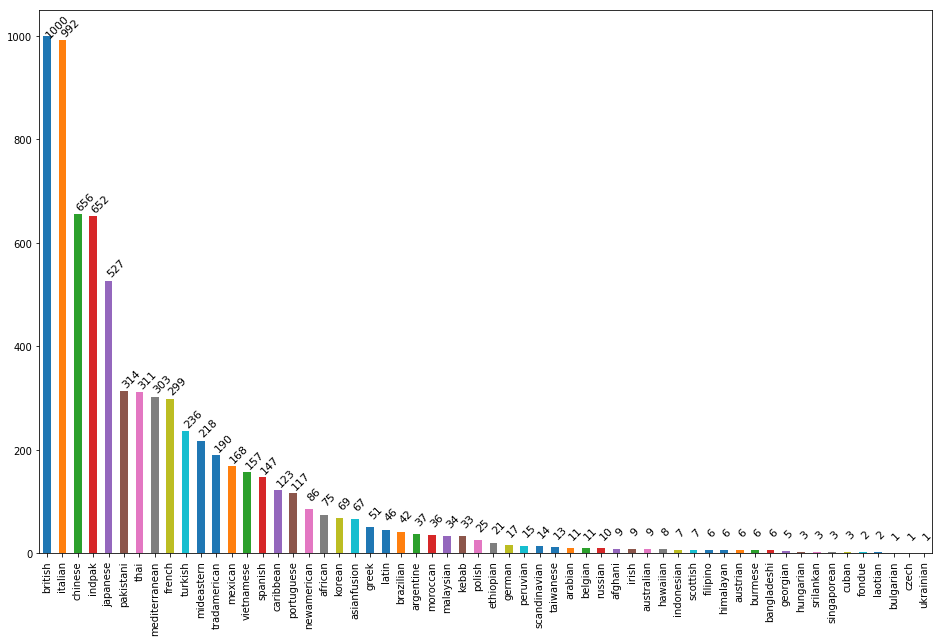

In [29]:
# create a bar plot
ax = final_df.category.value_counts().plot.bar(figsize=(16,10))
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.04, i.get_height()+30, \
            str(round((i.get_height()), 2)), fontsize=11,rotation=45)

In [30]:
general_cate = [{'British_Irish':['british','irish','scottish']},
               {'Italian':['italian']},
               {'Chinese':['chinese','taiwanese']},
               {'Indian':['indpak']},
               {'Japanese':['japanese']},
               {'Pakistani':['pakistani']},
               {'Southeast_Asian':['thai', 'vietnamese', 'malaysian', 'indonesian', 'bangladeshi', 'burmese', 'singaporean', 'srilankan', 'laotian']},
               {'Mediterranean':['mediterranean', 'greek', 'turkish', 'kebab']},
               {'French':['french']},
               {'Middle_Eastern':['mideastern','arabian']},
               {'American':['tradamerican','newamerican']},
               {'Mexican_Caribbean':['mexican','caribbean']},
               {'European_Other':['spanish', 'portuguese', 'polish', 'german', 'scandinavian', 'belgian', 'austrian', 'hungarian', 'fondue', 'czech', 'bulgarian']},
               {'African':['african','moroccan','ethiopian']},
               {'Korean':['korean']},
               {'Latin_American':['latin', 'brazilian', 'argentine', 'peruvian', 'cuban']},
               {'Other':['asianfusion', 'russian', 'australian', 'hawaiian', 'filipino', 'himalayan', 'ukrainian', 'georgian']}
               ]

In [32]:
# a new column was added to the dataframe and the general category of each entry was assigned
final_df.loc[:,'general_category'] = np.nan
for dicts in general_cate:
    for small_cate in list(dicts.values())[0]:
        final_df.loc[final_df.category == small_cate,['general_category']] = list(dicts.keys())[0]

In [26]:
# final_df.to_csv("london_restaurant_gen_categories.csv")

In [33]:
final_df.head()

,category,id,latitude,longitude,general_category
0,british,70Q-Ll18zb4aglXXbUG7lw,51.504058,-0.192783,British_Irish
1,british,MriFIF7b5TGXmBmrzMIS5w,51.515235,-0.121713,British_Irish
2,british,bJiVADMSTEKj0MjqiLrOPA,51.515378,-0.158236,British_Irish
3,british,IBV7BsXnv2gX68nWUARhjw,51.512935,-0.139414,British_Irish
4,british,b8u_D0Qlp0-nqSC6O2fMNw,51.485833,-0.161966,British_Irish


In [34]:
final_df.general_category.describe()

count              7217
unique               17
top       British_Irish
freq               1016
Name: general_category, dtype: object

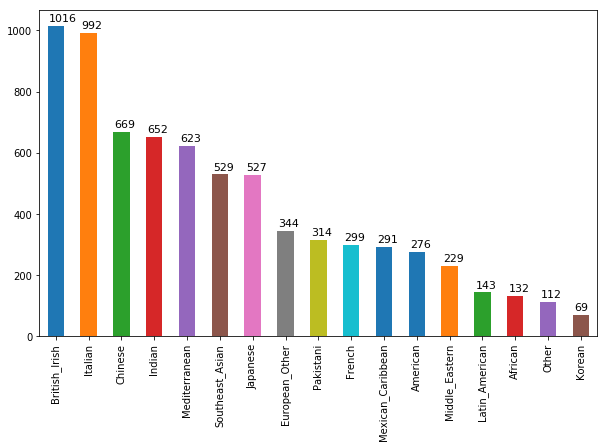

In [35]:
# create a bar plot
ax = final_df.general_category.value_counts().plot.bar(figsize=(10,6))
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.04, i.get_height()+15, \
            str(round((i.get_height()), 2)), fontsize=11)

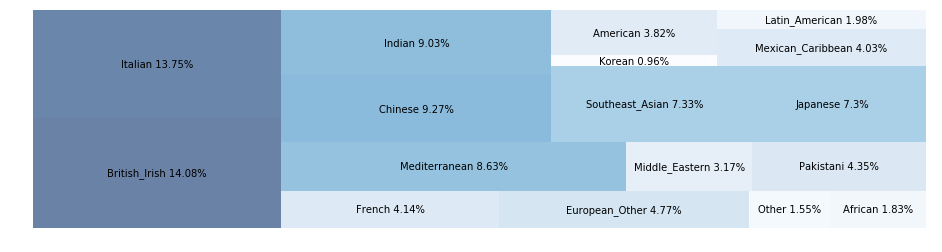

In [37]:
# plot a treemap to show the percentage of each category

#create a count list
sizes = []
for c in names:
    count = len(final_df[final_df.general_category==c])
    sizes.append(count)
    
# create a label list
names = list(final_df.general_category.unique())
del names[9]
labels = []
for i in range(17):
    pct = float(sizes[i]/sum(sizes))*100
    pct = round(pct,2)
    label = names[i]+' '+str(pct)+'%'
    labels.append(label)

# create a color palette, mapped to these values
cmap = plt.cm.Blues
mini=min(sizes)
maxi=max(sizes)
norm = colors.Normalize(vmin=mini, vmax=maxi)
color = [cmap(norm(value)) for value in sizes]
#Create the plot and resize it.
fig = plt.figure(figsize=(16,4))
sq.plot(label=labels,sizes=sizes,color=color,alpha=.6)
plt.axis('off')
plt.show()

According to the bar plot and the treemap, among the general categories, British_Irish cuisine and Italian cuisine are still the most prevailing genres, while Chinese cuisine and Indian cuisine also stays on the third and fourth places. These four categories together make up almost half of all the retaurants. It is not suprising to know that British_Irish cuisine is the most prevailing one since it is the local type, while there could be more underlying stories to tell about the commonness of Chinese and Indian cuisines. The numerous immigrants from these two countries could be one of the reasons account for it. However, since this is not the focus of this study, the exploration on reasons behind this composition of categories will remain as a possible future study here.

### 2.3 Spatial Aggregation<a id='aggregation'></a>
This part of the data preperation focuses on link the restaurant dataset and the spatial dataset of London wards together to produce a table of wards with restaurant count for every category. This is accomplished with three steps: transform the restaurant data to a GeoDataFrame object, assign the ward value for restaurants based on spatial join, and sum up restaurants of each genre for wards.
#### 2.3.1 Data Transformation<a id='transformation'></a>
This step will 1. create dummy vairables of general categories for the aggregation process; 2. create a geometry feature for the current DataFrame for spatial join.

In [38]:
# create dummy variables
dummy_df = pd.get_dummies(final_df,columns=['general_category'],prefix='gen_cat')

In [39]:
dummy_df.head()

,category,id,latitude,longitude,gen_cat_African,gen_cat_American,gen_cat_British_Irish,gen_cat_Chinese,gen_cat_European_Other,gen_cat_French,...,gen_cat_Italian,gen_cat_Japanese,gen_cat_Korean,gen_cat_Latin_American,gen_cat_Mediterranean,gen_cat_Mexican_Caribbean,gen_cat_Middle_Eastern,gen_cat_Other,gen_cat_Pakistani,gen_cat_Southeast_Asian
0,british,70Q-Ll18zb4aglXXbUG7lw,51.504058,-0.192783,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,british,MriFIF7b5TGXmBmrzMIS5w,51.515235,-0.121713,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,british,bJiVADMSTEKj0MjqiLrOPA,51.515378,-0.158236,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,british,IBV7BsXnv2gX68nWUARhjw,51.512935,-0.139414,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,british,b8u_D0Qlp0-nqSC6O2fMNw,51.485833,-0.161966,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
# convert to GeoDataFrame
# create a new column for the geometry information
dummy_df['geometry'] = list(zip(dummy_df.longitude, dummy_df.latitude))
dummy_df['geometry'] = dummy_df['geometry'].apply(Point)

# create the GeoDataFrame object
gdf = geopd.GeoDataFrame(dummy_df, geometry='geometry')

# reproject the data to the right projection
gdf.crs = {'init':'epsg:4326'}
gdf_rep = gdf.to_crs({'init':'epsg:27700'})

In [41]:
gdf_rep.crs

{'init': 'epsg:27700'}

In [42]:
gdf_rep.head()

,category,id,latitude,longitude,gen_cat_African,gen_cat_American,gen_cat_British_Irish,gen_cat_Chinese,gen_cat_European_Other,gen_cat_French,...,gen_cat_Japanese,gen_cat_Korean,gen_cat_Latin_American,gen_cat_Mediterranean,gen_cat_Mexican_Caribbean,gen_cat_Middle_Eastern,gen_cat_Other,gen_cat_Pakistani,gen_cat_Southeast_Asian,geometry
0,british,70Q-Ll18zb4aglXXbUG7lw,51.504058,-0.192783,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,POINT (525528.3710920924 179895.0664008702)
1,british,MriFIF7b5TGXmBmrzMIS5w,51.515235,-0.121713,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,POINT (530428.8258351785 181262.1514562725)
2,british,bJiVADMSTEKj0MjqiLrOPA,51.515378,-0.158236,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,POINT (527894.3145426174 181213.727215684)
3,british,IBV7BsXnv2gX68nWUARhjw,51.512935,-0.139414,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,POINT (529207.145168246 180975.0529325422)
4,british,b8u_D0Qlp0-nqSC6O2fMNw,51.485833,-0.161966,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,POINT (527718.0083670614 177921.6665368551)


#### 2.3.2 Spatial Join<a id='join'></a>
The boundary shapefile is loaded in this part, which can be accessed through this [repository](https://github.com/yunjinghu226/CASA0006DSSS.git). After the boundary layer and the restaurant point layer are ploted, it can be seen that the red dots representing restaurants generally form a square shape within the range of London. This indicates that there are issues in parameter settings when retrieving the data, leading to the incompleteness of the current restaurant dataset. In this case, a revisit of the data retrieving process is needed with different way of setting the parameters to complement the restaurant list. Therefore, the same processes of retrieving, cleaning, and tranforming the data were repeated. A total of 1,628 more restaurants are retrieved this time, and the composition of the categories does not show significant change compared to the previous dataset based on the new bar plot and treemap.<br>

The second plot of restaurant points seems to better represent the real situation of restaurant distrubition than the first plot, though there is still information obviously missing for the southeast portion of London. This could be caused by lacking of restaurant data or category information around that area in the Yelp server, or incompleteness of the searching range when retrieving the data. However, since it could take too much extra efforts to modifies the way of searching and there is a limit of 5,000 requests per day for the Yelp API, it is decided to continue with this dataset and exclude wards without restaurant data from the further analysis. Therefore, the spatial join is then conducted and the points not falling within the London boundary was deleted automatically, resulting in a dataframe of 8,669 restaurants with their ward information assigned.

In [43]:
# reading the Shapefile of London wards
london_wards = geopd.read_file("LondonWards.shp")

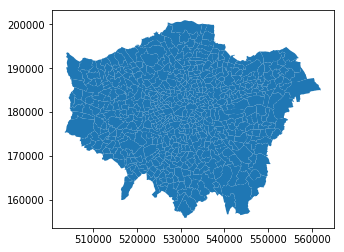

In [44]:
london_wards.plot()

In [45]:
london_wards.head()

,OBJECTID,WD11CD,WD11CDO,WD11NM,geometry
0,1,E05000001,00AAFA,City of London,"POLYGON ((532140.3009235589 182191.8991436698,..."
1,26,E05000026,00ABFX,Abbey,"POLYGON ((545296.398983812 184162.5994335059, ..."
2,27,E05000027,00ABFY,Alibon,"POLYGON ((549604.1007478246 185773.1998830065,..."
3,28,E05000028,00ABFZ,Becontree,"POLYGON ((547563.3998179231 186223.8991474248,..."
4,29,E05000029,00ABGA,Chadwell Heath,"POLYGON ((548880.999051149 191087.6001439542, ..."


In [46]:
london_wards.crs

{'init': 'epsg:27700'}

In [47]:
type(london_wards)

geopandas.geodataframe.GeoDataFrame

Next, plot the two GeoDataFrame on one plot

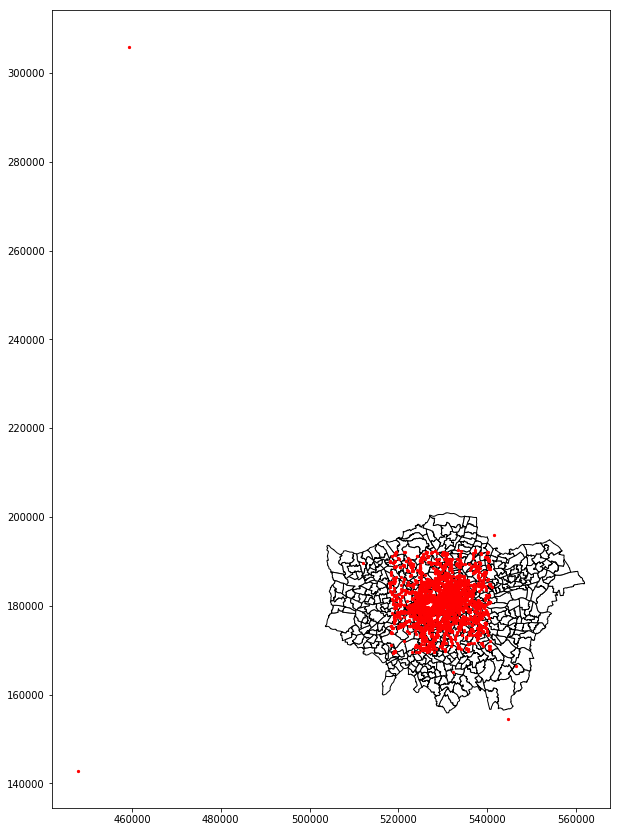

In [48]:
base = london_wards.plot(color='white', edgecolor='black',figsize=(10,16))
gdf_rep.plot(ax=base, marker='o', color='red', markersize=5)

##### Data Complementing and Re-processing<a id='revisit'></a>
To fetch the data of the outer area, functions are modified to take an extra argument of searching range. The four searching ranges are circles whose positions and radius are estimated to together cover the outer area of London.

In [49]:
outer_area = [{'longitude':0.15,'latitude':51.51,'radius':15000},
              {'longitude':-0.1,'latitude':51.35,'radius':17000},
              {'longitude':-0.4,'latitude':51.51,'radius':15000},
              {'longitude':-0.1,'latitude':51.64,'radius':15000}
             ]
# inner_area = {'location':'London'}

def search_area(offset,category,search_range):
    # return the list of businesses of certain category (string) in the specified search area (dictionary)
    
    params = {'term':'restaurants','locale':'en_GB','limit':50,'offset':offset,'categories':category}
    params.update(search_range)
    req=requests.get(url, params=params, headers=headers)
    return req.json()['businesses']

def business_retriever_2(category,search_range):
    # retrive the json data of a certian cusine category in the specified area and store as a list
    
    cate_results = []
    
    # test number of total restaurants in this category
    params = {'term':'restaurants','locale':'en_GB','limit':1,'offset':0,'categories':category}
    params.update(search_range)
    req=requests.get(url, params=params, headers=headers)
    
    if req.status_code == 200: # proceed only if the status code is 200
        total = req.json()['total']
        if total > 1000:
            print ('There are more than 1000 restaurants under category',category,'. Only the first 1000 will be returned.')
            for offset in range(0,1000,50):
                results = search_area(offset,category,search_range)
                cate_results.extend(results)
        elif total > 50 and total <= 1000:
            for offset in range(0,total,50):
                results = search_area(offset,category,search_range)
                cate_results.extend(results)
        else:
            cate_results.extend(search_area(0,category,search_range))
            
    else:
        print ('Error in retrieving data.')
        
    return cate_results

def extractor_2(categories,search_range):
    # extract useful info from data retrieved and combine restaurants of different categories into one list
    full_restaurants = []
    for category in categories: # loop through all the categories
        results = business_retriever_2(category,search_range)
        for restaurant in results: # loop through restaurants in each category
            if restaurant['is_closed'] == False: # only keep records that are still open
                rest_out = {}
                rest_out['id'] = restaurant['id']
                rest_out['category'] = category
                rest_out['longitude'] = restaurant['coordinates']['longitude']
                rest_out['latitude'] = restaurant['coordinates']['latitude']
                full_restaurants.append(rest_out)
    return full_restaurants

<font color=red>**Warning: the next cell could take a while to execute!**</font> The data extracted has been saved in json format available in this [repository](https://github.com/yunjinghu226/CASA0006DSSS.git). Thus, the code for retrieving and extracting data has been commented out and the json file will be loaded in.

In [56]:
'''
# loop through the outer areas, extract restaurant information and combine them with the previous restaurant list of inner area
new_rest_list = full_rest_list.copy()
for area in outer_area:
    resta_area = extractor_2(categories,area)
    new_rest_list.extend(resta_area)
'''

In [13]:
'''
# export the complete data retrieved as a json file

london_restaurants_complete = {'restaurants': new_rest_list}
with open("london_restaurants_complete.json",'w') as f:
    json.dump(london_restaurants_complete,f)
'''

In [50]:
with open("london_restaurants_complete.json",'r') as f:
    new_rest_list = json.load(f)['restaurants']

In [51]:
# transform the list to a dataframe
new_df = pd.DataFrame(new_rest_list)
# remove the duplicates and missing values
final_full_df = new_df.drop_duplicates(subset='id')
final_full_df = final_full_df.dropna()

In [52]:
final_full_df.head()

,category,id,latitude,longitude
0,british,70Q-Ll18zb4aglXXbUG7lw,51.504058,-0.192783
1,british,MriFIF7b5TGXmBmrzMIS5w,51.515235,-0.121713
2,british,bJiVADMSTEKj0MjqiLrOPA,51.515378,-0.158236
3,british,IBV7BsXnv2gX68nWUARhjw,51.512935,-0.139414
4,british,b8u_D0Qlp0-nqSC6O2fMNw,51.485833,-0.161966


In [53]:
len(final_full_df)

8854

In [54]:
# assign the general category for each entry based on the rule stated before
final_full_df.loc[:,'general_category'] = np.nan
for dicts in general_cate:
    for small_cate in list(dicts.values())[0]:
        final_full_df.loc[final_full_df.category == small_cate,['general_category']] = list(dicts.keys())[0]

In [55]:
final_full_df.head()

,category,id,latitude,longitude,general_category
0,british,70Q-Ll18zb4aglXXbUG7lw,51.504058,-0.192783,British_Irish
1,british,MriFIF7b5TGXmBmrzMIS5w,51.515235,-0.121713,British_Irish
2,british,bJiVADMSTEKj0MjqiLrOPA,51.515378,-0.158236,British_Irish
3,british,IBV7BsXnv2gX68nWUARhjw,51.512935,-0.139414,British_Irish
4,british,b8u_D0Qlp0-nqSC6O2fMNw,51.485833,-0.161966,British_Irish


In [56]:
# final_full_df.to_csv("london_restaurants_complete_gen_cate.csv")

In [57]:
# final_full_df = pd.read_csv("london_restaurants_complete_gen_cate.csv")

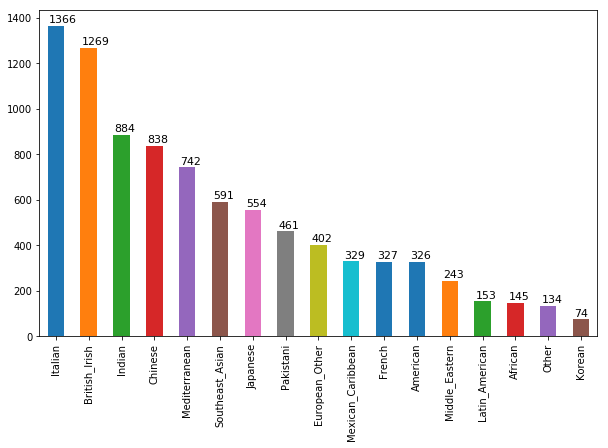

In [58]:
ax = final_full_df.general_category.value_counts().plot.bar(figsize=(10,6))
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.04, i.get_height()+15, \
            str(i.get_height()), fontsize=11)

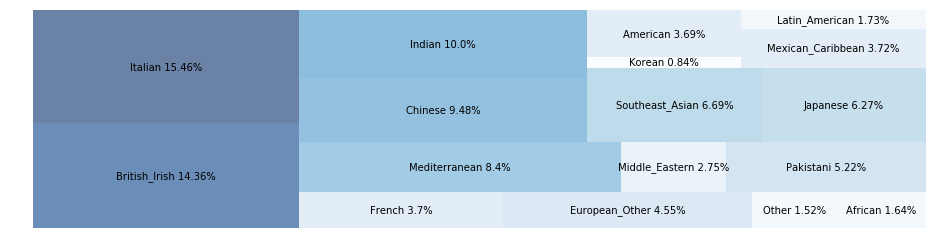

In [59]:
#create a count list
sizes = []
for c in names:
    count = len(final_full_df[final_full_df.general_category==c])
    sizes.append(count)

# create a label list
names = list(final_full_df.general_category.unique())
del names[9]
labels = []
for i in range(17):
    pct = float(sizes[i]/sum(sizes))*100
    pct = round(pct,2)
    label = names[i]+' '+str(pct)+'%'
    labels.append(label)

# create a color palette, mapped to these values
cmap = plt.cm.Blues
mini=min(sizes)
maxi=max(sizes)
norm = colors.Normalize(vmin=mini, vmax=maxi)
color = [cmap(norm(value)) for value in sizes]
#Create the plot and resize it.
fig = plt.figure(figsize=(16,4))
sq.plot(label=labels,sizes=sizes,color=color,alpha=.6)
plt.axis('off')
plt.show()

In [60]:
# create dummy variables
full_dummy_df = pd.get_dummies(final_full_df,columns=['general_category'],prefix='gen_cat')

In [61]:
full_dummy_df.head()

,category,id,latitude,longitude,gen_cat_African,gen_cat_American,gen_cat_British_Irish,gen_cat_Chinese,gen_cat_European_Other,gen_cat_French,...,gen_cat_Italian,gen_cat_Japanese,gen_cat_Korean,gen_cat_Latin_American,gen_cat_Mediterranean,gen_cat_Mexican_Caribbean,gen_cat_Middle_Eastern,gen_cat_Other,gen_cat_Pakistani,gen_cat_Southeast_Asian
0,british,70Q-Ll18zb4aglXXbUG7lw,51.504058,-0.192783,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,british,MriFIF7b5TGXmBmrzMIS5w,51.515235,-0.121713,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,british,bJiVADMSTEKj0MjqiLrOPA,51.515378,-0.158236,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,british,IBV7BsXnv2gX68nWUARhjw,51.512935,-0.139414,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,british,b8u_D0Qlp0-nqSC6O2fMNw,51.485833,-0.161966,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# convert the DataFrame to GeoDataFrame
# create geometry column
coordinates = list(zip(full_dummy_df.longitude,full_dummy_df.latitude))
full_dummy_df['Coordinates'] = coordinates
full_dummy_df['Coordinates'] = full_dummy_df['Coordinates'].apply(Point)
# create GeoDataFrame
full_gpd = geopd.GeoDataFrame(full_dummy_df,geometry='Coordinates')
# reproject the data to the right projection
full_gpd.crs = {'init':'epsg:4326'}
full_gpd_rep = full_gpd.to_crs({'init':'epsg:27700'})

In [63]:
full_gpd_rep.head()

,category,id,latitude,longitude,gen_cat_African,gen_cat_American,gen_cat_British_Irish,gen_cat_Chinese,gen_cat_European_Other,gen_cat_French,...,gen_cat_Japanese,gen_cat_Korean,gen_cat_Latin_American,gen_cat_Mediterranean,gen_cat_Mexican_Caribbean,gen_cat_Middle_Eastern,gen_cat_Other,gen_cat_Pakistani,gen_cat_Southeast_Asian,Coordinates
0,british,70Q-Ll18zb4aglXXbUG7lw,51.504058,-0.192783,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,POINT (525528.3710920924 179895.0664008702)
1,british,MriFIF7b5TGXmBmrzMIS5w,51.515235,-0.121713,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,POINT (530428.8258351785 181262.1514562725)
2,british,bJiVADMSTEKj0MjqiLrOPA,51.515378,-0.158236,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,POINT (527894.3145426174 181213.727215684)
3,british,IBV7BsXnv2gX68nWUARhjw,51.512935,-0.139414,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,POINT (529207.145168246 180975.0529325422)
4,british,b8u_D0Qlp0-nqSC6O2fMNw,51.485833,-0.161966,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,POINT (527718.0083670614 177921.6665368551)


In [64]:
len(full_gpd_rep)

8854

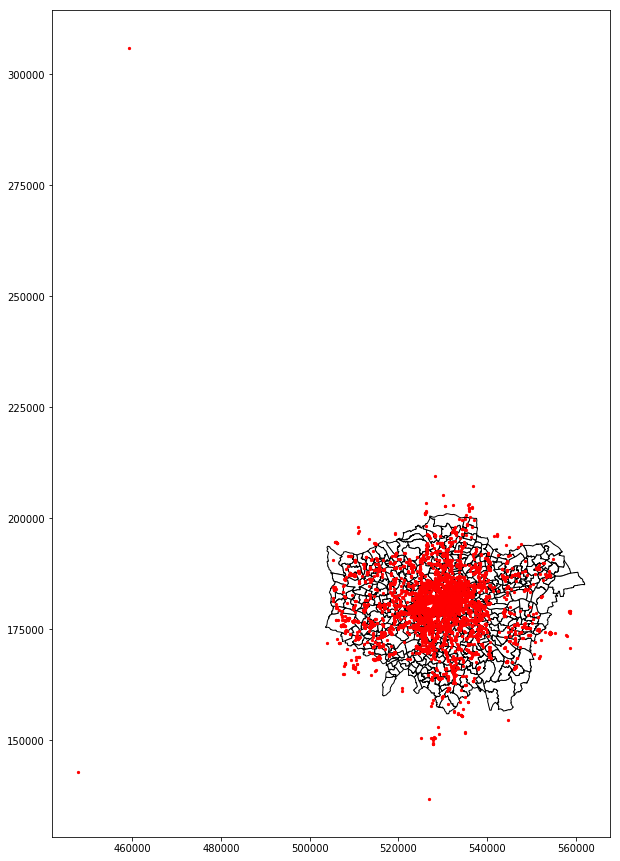

In [65]:
# plot the layers
base = london_wards.plot(color='white', edgecolor='black',figsize=(10,16))
full_gpd_rep.plot(ax=base, marker='o', color='red', markersize=5)

##### Spatial Join<a id='rejoin'></a>

In [66]:
# join the ward data to restaurant GeoDataFrame
rest_with_ward = geopd.sjoin(full_gpd_rep, london_wards, how="inner", op='intersects')

In [67]:
len(rest_with_ward)

8669

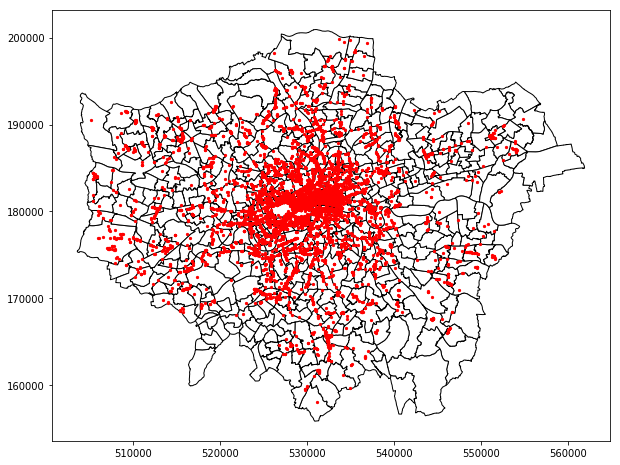

In [68]:
# plot the layers
base = london_wards.plot(color='white', edgecolor='black',figsize=(10,16))
rest_with_ward.plot(ax=base, marker='o', color='red', markersize=5)

#### 2.3.3 Spatial Dissolve<a id='dissolve'></a>
In this step, the table returned from the last process is re-organized to the one listing the number of restaurants in each category for every ward with at least one restaurant. There are totally 526 wards remained, meaning 99 wards without restaurant data will be excluded from the following analysis. A summry table describing the distribution of each category among the wards is then produced.

In [69]:
# sum up the number of restaurants in different categories for each ward
rest_agg = rest_with_ward.drop(columns=['category','id','latitude','longitude','index_right','OBJECTID','WD11CDO'])
ward_cate_count = rest_agg.groupby(['WD11NM','WD11CD'],as_index=False).sum()
ward_cate_count.head()

,WD11NM,WD11CD,gen_cat_African,gen_cat_American,gen_cat_British_Irish,gen_cat_Chinese,gen_cat_European_Other,gen_cat_French,gen_cat_Indian,gen_cat_Italian,gen_cat_Japanese,gen_cat_Korean,gen_cat_Latin_American,gen_cat_Mediterranean,gen_cat_Mexican_Caribbean,gen_cat_Middle_Eastern,gen_cat_Other,gen_cat_Pakistani,gen_cat_Southeast_Asian
0,Abbey,E05000026,0,0,1,1,1,0,2,0,0,0,0,1,0,0,0,2,0
1,Abbey,E05000455,0,0,0,3,0,0,0,2,2,0,0,1,0,3,0,0,3
2,Abbey Road,E05000630,1,0,1,2,0,1,0,2,0,0,0,1,0,1,0,1,1
3,Abingdon,E05000382,0,1,3,0,1,1,2,6,1,0,0,2,0,3,2,0,3
4,Acton Central,E05000170,0,0,0,1,0,0,4,1,2,0,0,0,0,1,0,0,0


In [70]:
# ward_cate_count.to_csv("ward_cate_count.csv")

In [71]:
# ward_cate_count = pd.read_csv("ward_cate_count.csv")

In [72]:
des_table = ward_cate_count.T[2:]
des_table.head()

,0,1,2,3,4,5,6,7,8,9,...,516,517,518,519,520,521,522,523,524,525
gen_cat_African,0,0,1,0,0,0,0,0,0,0,...,0,0,1,1,0,1,1,1,0,0
gen_cat_American,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
gen_cat_British_Irish,1,0,1,3,0,0,1,0,1,0,...,0,0,1,0,0,0,1,0,1,1
gen_cat_Chinese,1,3,2,0,1,0,1,0,0,2,...,0,0,3,2,0,2,2,0,0,0
gen_cat_European_Other,1,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [73]:
# a column for total number of restaurants
total_num = des_table.sum(axis=1)

# a column for number of wards with a restaurants
def count_ward(row):
    count = 0
    for i in range(509):
        if row[i] != 0:
            count += 1
    return count
with_one = des_table.apply(count_ward,axis=1)

# a column for max number in a ward
max_num = des_table.max(axis=1)

# a column for mean number in a ward
mean_num = des_table.mean(axis=1)

# append the these columns to the table
des_table['total_num'] = total_num
des_table['num_ward_with_one'] = with_one
des_table['max_num'] = max_num
des_table['mean_num'] = mean_num

In [74]:
descript = des_table.iloc[:,526:]
def highlight_max3(s):
    # highlight the maximum 3 in a Series yellow.
    thred = s.sort_values(ascending=False)[2]
    is_max = s >= thred
    return ['background-color: orange' if v else '' for v in is_max]

In [75]:
descript.style.apply(highlight_max3)

,total_num,num_ward_with_one,max_num,mean_num
gen_cat_African,142,90,5,0.269962
gen_cat_American,318,145,30,0.604563
gen_cat_British_Irish,1242,257,106,2.36122
gen_cat_Chinese,813,304,110,1.54563
gen_cat_European_Other,391,181,26,0.743346
gen_cat_French,323,132,34,0.614068
gen_cat_Indian,857,313,32,1.62928
gen_cat_Italian,1339,285,106,2.54563
gen_cat_Japanese,546,147,61,1.03802
gen_cat_Korean,72,27,15,0.136882


This table again highlights the prevelance of the category British_Irish, Italian, Chinese, and Indian cuisines as the top three of the four indexes all come from these categories. Italian cuisine has the most total numbers and mean number of restaurants in the involved study area, Indian cuisine spreads to the most number of wards, and Chinese cuisine shows a concentration as it has the most maximum number of restaurants in one ward.

---

## 3. Analysis and Result Intepretation<a id='analysis'></a>
The analysis is performed in two aspects: mapping the food diversity score and exploring the relationship between the food diversity and other features of wards. 
### 3.1 Diversity Score<a id='score'></a>
The diversity score was calculated as Simpson's Diversity Index (SDI) based on the formula below, which is how the diversity scores are calculated in the census report.<br>
<center>$$SDI=\frac{1}{sum_{i=1}^n \frac{1}{Pi}^2}$$</center><br>
In the formula, Pi stands for the possibility of finding a restaurant of certain category out of all the restaurants in the area, which is basically the proportion of that category. n stands for the number of existing categories in the area. Thus, The minimum possible diversity score will be 1, the situation where there only one genre in the ward. The maximum possible diversity will be 17, meaning the ward has all the 17 genres of restaurants and there are equal numbers of them. That is to say, within a ward, the more genres, the more evenly distributed, the higher the score.<br>

After the score is calculated, it was mapped with a choropleth map, on which deeper color indidcates higher score. The map suggested that wards around central London tend to have more diversity, and this spatial pattern of the food diversity could be caused by certain underlying reasons. The statistic summary and histogram show that the distribution of the score is highly left screwed. There are 69 wards (over 10%) with the score of 1, which means there only one category present in the ward. This could be the result of missing information on restaurants so that there is no sufficient samples within those wards. In this case, the discussion on the least diverse ward will be meaningless. Meanwhile, the most diverse ward is Hammersmith Broadway and the top ten wards are all located around central London.

In [79]:
# create a column for total number of restaurants
ward_div_score = ward_cate_count[:]
ward_div_score.loc[:,'total'] = ward_div_score.sum(axis=1)

In [81]:
# calculate the diversity score
def dscore(row):
    m = 0
    for i in range(2,19):
        a = (float(row[i]/row[19]))**2
        m += a
    return 1/m
ward_div_score.loc[:,'div_score'] = ward_div_score.apply(dscore,axis=1)
ward_div_score.head()

,WD11NM,WD11CD,gen_cat_African,gen_cat_American,gen_cat_British_Irish,gen_cat_Chinese,gen_cat_European_Other,gen_cat_French,gen_cat_Indian,gen_cat_Italian,...,gen_cat_Korean,gen_cat_Latin_American,gen_cat_Mediterranean,gen_cat_Mexican_Caribbean,gen_cat_Middle_Eastern,gen_cat_Other,gen_cat_Pakistani,gen_cat_Southeast_Asian,total,div_score
0,Abbey,E05000026,0,0,1,1,1,0,2,0,...,0,0,1,0,0,0,2,0,8,5.333333
1,Abbey,E05000455,0,0,0,3,0,0,0,2,...,0,0,1,0,3,0,0,3,14,5.444444
2,Abbey Road,E05000630,1,0,1,2,0,1,0,2,...,0,0,1,0,1,0,1,1,11,8.066667
3,Abingdon,E05000382,0,1,3,0,1,1,2,6,...,0,0,2,0,3,2,0,3,25,7.911392
4,Acton Central,E05000170,0,0,0,1,0,0,4,1,...,0,0,0,0,1,0,0,0,9,3.521739


In [82]:
# join this DataFrame back to the london_wards GeoDataFrame
ward_score = ward_div_score.iloc[:,[0,1,-1]]
london_wards_score = london_wards.merge(ward_score,on='WD11CD')
london_wards_score.head()

,OBJECTID,WD11CD,WD11CDO,WD11NM_x,geometry,WD11NM_y,div_score
0,1,E05000001,00AAFA,City of London,"POLYGON ((532140.3009235589 182191.8991436698,...",City of London,7.966819
1,26,E05000026,00ABFX,Abbey,"POLYGON ((545296.398983812 184162.5994335059, ...",Abbey,5.333333
2,28,E05000028,00ABFZ,Becontree,"POLYGON ((547563.3998179231 186223.8991474248,...",Becontree,3.000000
3,29,E05000029,00ABGA,Chadwell Heath,"POLYGON ((548880.999051149 191087.6001439542, ...",Chadwell Heath,1.000000
4,30,E05000030,00ABGB,Eastbrook,"POLYGON ((551552.8997256374 187363.400204489, ...",Eastbrook,1.000000


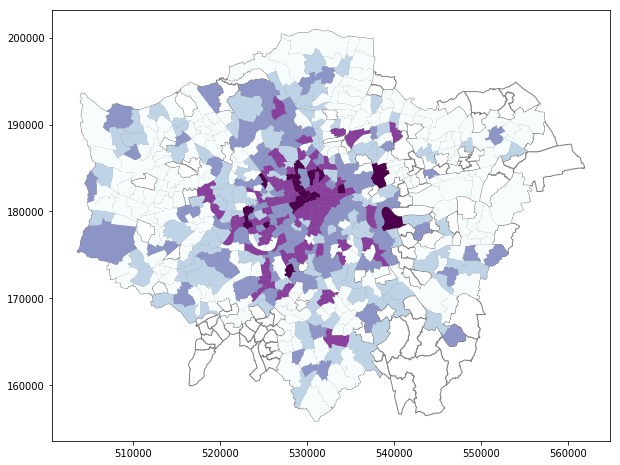

In [83]:
base = london_wards.plot(color='white', edgecolor='grey',figsize=(10,16))
london_wards_score.plot(ax=base, column='div_score',cmap='BuPu',scheme='equal_interval')

In [84]:
ward_score.div_score.describe()

count    526.000000
mean       4.417340
std        2.546566
min        1.000000
25%        2.272727
50%        4.000000
75%        6.368421
max       11.460317
Name: div_score, dtype: float64

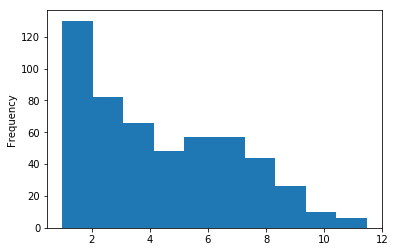

In [85]:
ward_score.div_score.plot('hist')

In [86]:
len(ward_score[ward_score.div_score==1])

69

In [275]:
ward_score.sort_values(by='div_score',ascending=False).head(10)

,WD11NM,WD11CD,div_score
217,Hammersmith Broadway,E05000256,11.460317
381,Regent's Park,E05000142,11.413115
355,Peninsula,E05000225,11.187845
141,Earl's Court,E05000388,10.975610
40,Bloomsbury,E05000129,10.730953
68,Camden Town with Primrose Hill,E05000130,10.444444
438,Stratford and New Town,E05000492,10.289377
326,Nightingale,E05000618,10.255814
400,Shepherd's Bush Green,E05000263,9.838298
496,West End,E05000649,9.786058


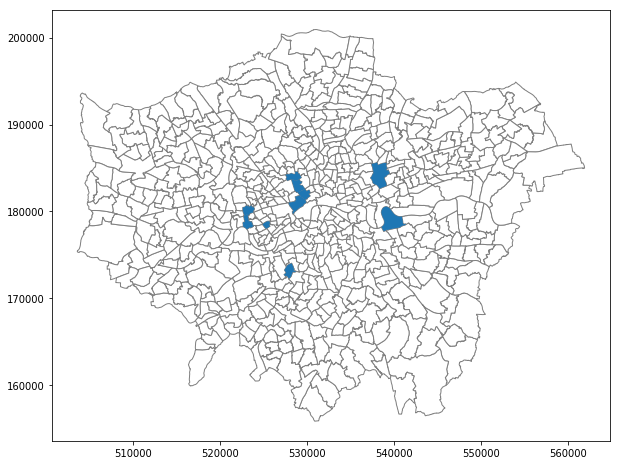

In [276]:
base = london_wards.plot(color='white', edgecolor='grey',figsize=(10,16))
london_wards_score[london_wards_score.div_score>=9.786058].plot(ax=base)

### 3.2 Correlation and Regression Analysis<a id='relationship'></a>
The objective of this part is to explore whether the food diversity is correlated with any other features of the society. To do so, the correlation analysis is performed first to evaluate the strength of linkage between variables. Then a linear regression model and a support vector regression model are created to see if the diversity score can be predicted through other correlated attributes.
#### 3.2.1 Correlation<a id='correlation'></a>

In [87]:
census = pd.read_csv("related_census_info.csv")

In [88]:
combined = pd.merge(census,ward_score,on='WD11CD',how='inner')

In [89]:
combined.head()

,WD11CD,WD11NM_x,eth_div_score,pct_wk_age,pct_not_born_uk,pct_esl_household,emp_rate,new_migrant_workers_rate,med_house_income,avg_gcse,pct_level4,WD11NM_y,div_score
0,E05000026,Abbey,8.36,69.014180,57.3,25.7,60.348077,108.695652,33920.0,317.657759,34.5,Abbey,5.333333
1,E05000028,Becontree,3.47,65.912673,30.1,10.5,61.192441,38.554217,33000.0,295.451381,20.6,Becontree,3.000000
2,E05000029,Chadwell Heath,3.08,61.500000,24.8,6.5,63.639393,26.271186,33920.0,293.437838,19.5,Chadwell Heath,1.000000
3,E05000030,Eastbrook,2.03,65.666790,19.0,4.5,68.221661,18.439716,37400.0,305.948276,18.5,Eastbrook,1.000000
4,E05000031,Eastbury,3.74,65.170994,32.2,11.9,61.540544,48.920863,32870.0,315.667066,20.0,Eastbury,1.000000


In [90]:
len(combined)

525

In [91]:
combined.describe()

,eth_div_score,pct_wk_age,pct_not_born_uk,pct_esl_household,emp_rate,new_migrant_workers_rate,med_house_income,avg_gcse,pct_level4,div_score
count,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000
mean,4.274152,69.082344,37.569905,13.490476,69.528605,46.355316,39672.342857,327.449049,39.325524,4.410579
std,1.899824,5.060521,13.094589,7.309720,6.392131,29.845028,7655.102801,21.420669,12.677268,2.544265
min,1.260000,59.013812,7.100000,1.100000,46.113208,2.857143,25090.000000,279.871429,14.900000,1.000000
25%,2.810000,65.102109,29.600000,7.900000,65.151178,23.000000,34260.000000,311.658654,29.300000,2.272727
50%,4.000000,68.185375,38.700000,12.800000,70.227449,41.116751,38240.000000,324.761728,37.700000,4.000000
75%,5.610000,72.849741,46.300000,18.500000,74.251497,64.069264,44010.000000,340.534783,48.700000,6.368421
max,10.440000,83.921233,68.500000,36.700000,83.901786,149.180328,88330.000000,396.213158,68.700000,11.460317


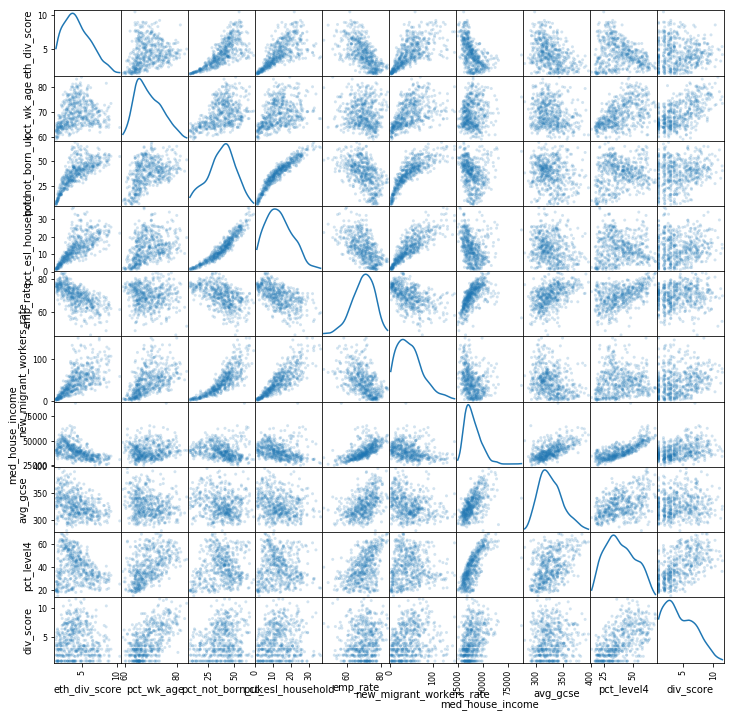

In [92]:
sct_mat = pd.plotting.scatter_matrix(combined, alpha=0.2, figsize=(12, 12), diagonal='kde')

In [93]:
combined.corr().style.background_gradient(cmap='coolwarm')

,eth_div_score,pct_wk_age,pct_not_born_uk,pct_esl_household,emp_rate,new_migrant_workers_rate,med_house_income,avg_gcse,pct_level4,div_score
eth_div_score,1,0.223833,0.754952,0.714622,-0.63654,0.669445,-0.542569,-0.382495,-0.230347,-0.014578
pct_wk_age,0.223833,1,0.453971,0.363188,-0.0841614,0.510115,0.112713,-0.184322,0.510081,0.593054
pct_not_born_uk,0.754952,0.453971,1,0.945455,-0.516152,0.833351,-0.170704,-0.170522,0.149386,0.206223
pct_esl_household,0.714622,0.363188,0.945455,1,-0.576801,0.843032,-0.270097,-0.188569,-0.0142958,0.108726
emp_rate,-0.63654,-0.0841614,-0.516152,-0.576801,1,-0.501209,0.603017,0.463107,0.483673,0.116721
new_migrant_workers_rate,0.669445,0.510115,0.833351,0.843032,-0.501209,1,-0.282574,-0.27346,0.0419736,0.204091
med_house_income,-0.542569,0.112713,-0.170704,-0.270097,0.603017,-0.282574,1,0.604604,0.779122,0.355622
avg_gcse,-0.382495,-0.184322,-0.170522,-0.188569,0.463107,-0.27346,0.604604,1,0.437658,0.0887088
pct_level4,-0.230347,0.510081,0.149386,-0.0142958,0.483673,0.0419736,0.779122,0.437658,1,0.581768
div_score,-0.014578,0.593054,0.206223,0.108726,0.116721,0.204091,0.355622,0.0887088,0.581768,1


#### 3.2.2 Multilinear Regression<a id='multilinear'></a>

In [94]:
X = combined[['pct_wk_age','med_house_income','pct_level4']].values.reshape(len(combined), 3)
y = combined['div_score'].values.reshape(len(combined), 1)
train_d,test_d,train_p,test_p = train_test_split(X,y,test_size=0.2)

In [95]:
mlr = LinearRegression().fit(train_d,train_p)

In [96]:
mlr.coef_

array([[2.13253936e-01, 1.39039603e-05, 6.86232066e-02]])

In [97]:
mlr.score(train_d,train_p)

0.469369545452944

In [98]:
mlr.score(test_d,test_p)

0.4056660693145878

#### 3.2.3 Support Vector Regression<a id='svr'></a>

In [100]:
svr = SVR(kernel='rbf', C=100, gamma=100)

In [101]:
svr.fit(train_d,train_p.ravel())

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=100,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [102]:
svr.score(train_d,train_p.ravel())

0.9985172440195885

In [103]:
svr.score(test_d,test_p.ravel())

-0.0024863872814793186

According to the scatter plot matrix and correlation matrix, the diversity score has relatively stronger positive correlation with percent of population at working age (the adult population) and percent of population with qualification of level 4 or higher, which correspond to the Park's (2017) findings that the heterogeneity of the restaurants increases as the population received longer time of education. Meanwhile, the result also suggests weak positive correaltion with medium household income, which differs from the situation in American cities analyzed in Park's (2017) paper.<br>

Based on these results, the three variables mentioned above are used as independent variables to construct the regression models. The score (i.e. R-squared) of the multilinear regression model is about 0.41, meaning only 41% of the variability of the diversity score can be explained by those three indipendent variables, suggesting a week ability of the model to predict the diversity score with them. However, the score of -0.002 indicates the SVR model completely failed at building a effective relationship between the diversity score and other variables. 

------

## 4. Conclusion and Limitations<a id='conclusion'></a>
To conclude, the research questions raised at the beginning can be answered now based on all the analysis. 
1. There is apparent variation in food diversity among London wards and those with higher diversity tend to concentrate around central London. 
2. Among the features involved in this study, although the adult percentage, level 4 qualification percentage, and medium house income are found to be somehow positively correlated to cuisine diversity, the regression models trained from this subset of data does not have enough ability to accurately depict the relationship between them. 

The limitations of this study mainly lie in two aspects. One is the quality of the dataset retrieved from Yelp. Although it is demonstrated that the Yelp data is able to provide some insights on the food diversity of London, due to the reasons that Yelp may not necessarily include information for all the businesses, that the category information may not be accurate, and that the data is incomplete for some wards and cuisine types, the diversity score and its spatial pattern may have not reflet the real situation. The other aspect of limitation is that the relationship analysis only involved very limited number of indipendent variables and models, and the inaccuracy of the diversity score calculated from the incomplete dataset could have also influence the validity of the analysis results. Therefore, this study can be greatly improved with better data source, more carefully designed data retrieving and cleaning processes, and more comprehensive consideration on the relationship with other features.

-------

## References<a id='reference'></a>

Park, K., 2017. Ethnic Foodscapes: Foreign Cuisines in the United States. Food, Culture & Society 20, 365–393. https://doi.org/10.1080/15528014.2017.1337390